In [1]:
# ----------------------------
# 1. Imports & Data Loading
# ----------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("../../data/simulation_security_labels_n-1.csv")
data["status_binary"] = data["status"].map({"secure": 1, "insecure": 0})
columns_to_drop = [
    "timestamp", "status", "status_binary", 
    "max_line_loading_percent_basecase",
    "min_bus_voltage_pu_basecase",
    "max_bus_voltage_pu_basecase",
    "max_line_loading_percent_contingency",
    "min_bus_voltage_pu_contingency",
    "max_bus_voltage_pu_contingency"
]

features_df = data.drop(columns=columns_to_drop, axis=1, errors="ignore")
target = data["status_binary"]

In [2]:
# ----------------------------
# 2. Active Learning Simulation Setup
# ----------------------------
initial_size = 100
batch_size = 200
X_pool = features_df.copy()
y_pool = target.copy()

# Random initial sample
initial_idx = np.random.choice(range(len(X_pool)), size=initial_size, replace=False)
X_labeled = X_pool.iloc[initial_idx]
y_labeled = y_pool.iloc[initial_idx]
X_pool = X_pool.drop(index=initial_idx)
y_pool = y_pool.drop(index=initial_idx)

X_val, y_val = X_pool[:500], y_pool[:500]  # Validation set for testing model accuracy

In [3]:
# ----------------------------
# 3. Active Learning Loop
# ----------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
accuracies = []

for iteration in range(5):
    model.fit(X_labeled, y_labeled)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    print(f"Iteration {iteration+1} - Accuracy: {acc:.4f}")

    # Uncertainty Sampling: Select points with least confident predictions
    probs = model.predict_proba(X_pool)
    uncertainty = np.abs(probs[:, 0] - 0.5)
    uncertain_idx = uncertainty.argsort()[:batch_size]

    # Add the most uncertain samples to labeled set
    X_labeled = pd.concat([X_labeled, X_pool.iloc[uncertain_idx]])
    y_labeled = pd.concat([y_labeled, y_pool.iloc[uncertain_idx]])
    X_pool = X_pool.drop(index=X_pool.iloc[uncertain_idx].index)
    y_pool = y_pool.drop(index=y_pool.iloc[uncertain_idx].index)

Iteration 1 - Accuracy: 0.8020
Iteration 2 - Accuracy: 0.8960
Iteration 3 - Accuracy: 0.9380
Iteration 4 - Accuracy: 0.9380
Iteration 5 - Accuracy: 0.9560


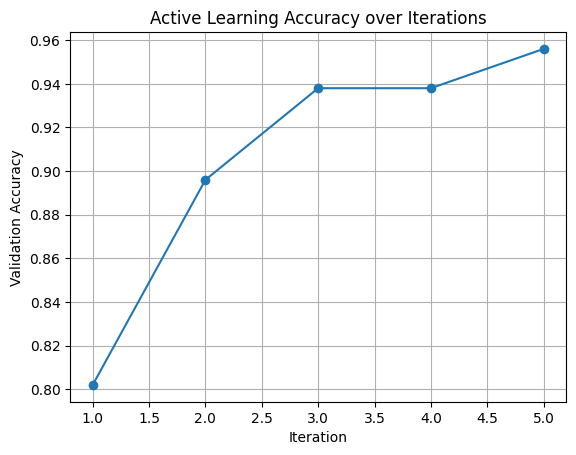

In [4]:
# ----------------------------
# 4. Plot Accuracy over Iterations
# ----------------------------
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.title("Active Learning Accuracy over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()